# DETECTION OF BRAIN ILLNESSES USING MACHINE LEARNING
### Vignesh Murali NUID: 001886775

## Alzheimer's Disease 

## Aim
The primary aim of this project is to find the most efficient way of predicting the onset of Alzheimer's disease in a person aged over the age of 60 using Machine Learning concepts.

## What is Alzheimer's Disease?
Alzheimer's disease is the most common cause of dementia — a group of brain disorders that cause the loss of intellectual and social skills. In Alzheimer's disease, the brain cells degenerate and die, causing a steady decline in memory and mental function.

## The Dataset
The dataset has been obtained from the Open Access Series of Imaging Studies (OASIS) which is a project aimed at making MRI data sets of the brain freely available to the scientific community. https://www.oasis-brains.org/

- This set consists of a longitudinal collection of 150 subjects aged 60 to 96. 
- Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. 
- For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included.

## Column Descriptors
| Column | Description                         |
|--------|-------------------------------------|
| EDUC   | Years of education.                 |
| SES    | Socio-economic status               |
| MMSE   | Mini Mental State Examination       |
| CDR    | Clinical Dementia Rating            |
| eTIV   | Estimated Total Intercranial Volume |
| nWBV   | Normalized Whole Brain Volume       |
| ASF    | Atlas Scaling Factor                |

MMSE:
- 25-30 Barely significant
- 20-25 Mild
- 10-20 Moderate
- 0-10 Severe

CDR:
- 0 No dementia
- 0.5 Slightly Dementia
- 1 Demented
- 2 Severely Demented


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn.preprocessing import normalize, StandardScaler
from scipy.stats import multivariate_normal
from collections import Counter
df=pd.read_csv('oasis_longitudinal.csv')
df2=df


C:\Users\vigne\Anaconda3\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


## DATA CLEANING

Checking number of null values

In [6]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [7]:
df = df.fillna(method='ffill')
df.isnull().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

Insert the last known value in the null fields.

In [8]:
df = df.drop('Hand',1)


We are dropping this column because all of the patients are right handed.

## EXPLORATORY DATA ANALYSIS


Let us try to further understand the nature of the data and see if we can make any interesting inferences from graphical representations of the data.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 14 columns):
Subject ID    373 non-null object
MRI ID        373 non-null object
Group         373 non-null object
Visit         373 non-null int64
MR Delay      373 non-null int64
M/F           373 non-null object
Age           373 non-null int64
EDUC          373 non-null int64
SES           373 non-null float64
MMSE          373 non-null float64
CDR           373 non-null float64
eTIV          373 non-null int64
nWBV          373 non-null float64
ASF           373 non-null float64
dtypes: float64(5), int64(5), object(4)
memory usage: 40.9+ KB


In [10]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.455764,27.335121,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134171,3.674641,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [11]:
df.corr()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Visit,1.000000,0.920009,0.183213,0.024615,-0.040956,-0.030325,0.002325,0.117428,-0.126682,-0.120399
MR Delay,0.920009,1.000000,0.205357,0.051630,-0.028744,0.065058,-0.062915,0.119624,-0.105586,-0.123545
Age,0.183213,0.205357,1.000000,-0.027886,-0.042893,0.055848,-0.026257,0.042348,-0.518359,-0.035067
EDUC,0.024615,0.051630,-0.027886,1.000000,-0.671277,0.196159,-0.153121,0.257015,-0.012200,-0.241752
SES,-0.040956,-0.028744,-0.042893,-0.671277,1.000000,-0.130272,0.069921,-0.243555,0.096337,0.230536
MMSE,-0.030325,0.065058,0.055848,0.196159,-0.130272,1.000000,-0.683312,-0.028163,0.341315,0.035034
CDR,0.002325,-0.062915,-0.026257,-0.153121,0.069921,-0.683312,1.000000,0.022819,-0.344819,-0.029340
eTIV,0.117428,0.119624,0.042348,0.257015,-0.243555,-0.028163,0.022819,1.000000,-0.210122,-0.988877
nWBV,-0.126682,-0.105586,-0.518359,-0.012200,0.096337,0.341315,-0.344819,-0.210122,1.000000,0.213476
ASF,-0.120399,-0.123545,-0.035067,-0.241752,0.230536,0.035034,-0.029340,-0.988877,0.213476,1.000000


The columns are not highly correlated hence we wont experience redundancy in the features used for classification.

In [12]:
demented = df.loc[df['Group']=='Demented']
nondemented = df.loc[df['Group']=='Nondemented']
converted = df.loc[df['Group']=='Converted']

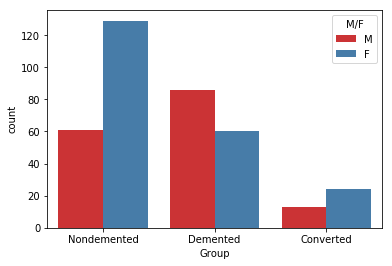

In [13]:
sns.countplot(x='Group',data=df,hue='M/F',palette='Set1')
plt.show()

From this countplot, it is pretty clear that more men have Alzheimer's and more women have been converted after having Alzheimer's in the past.

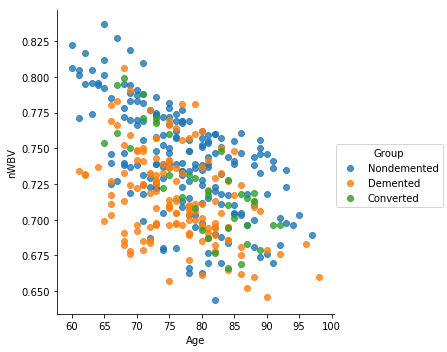

In [14]:
sns.lmplot(x='Age', y='nWBV',hue='Group',data=df,fit_reg=False)
plt.show()

We observe from this scatterplot that most demented patients have a normalized brain volume between 0.650 and 0.750.
Most nondemented patients have a higher brain volume.

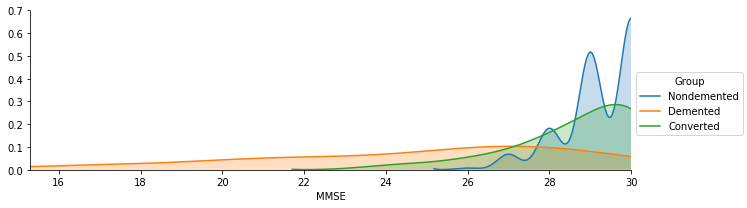

In [15]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)
plt.show()

Demented patients have extremely low Mini Mental State Examination Scores compared to Nondemented patients, we can clearly see this
through this density plot.

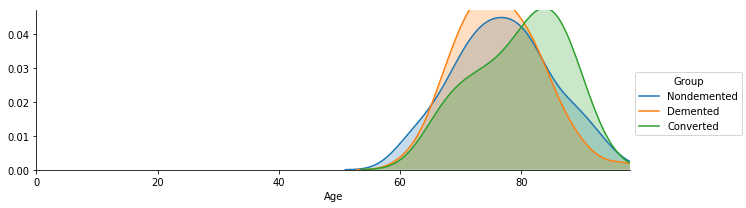

In [16]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()

plt.show()

Most demented patients are between the ages of 60-80
This is probably because patients with dementia cannot live as long as nondemented patients.

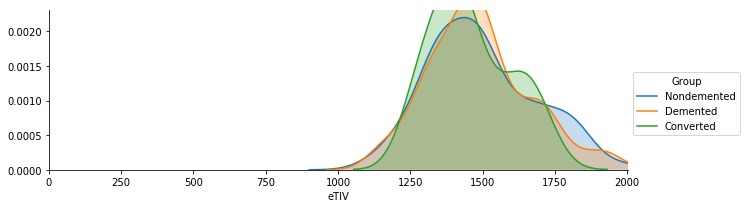

In [17]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()

plt.show()

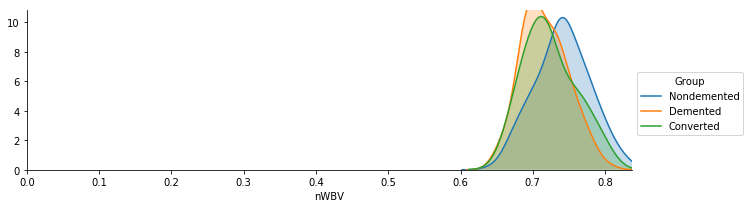

In [18]:

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()

plt.show()


## CLASSIFICATION MODELS

### We are considering the following conventional maching learning algorithms for multi-class classification:
- Random Forest Classifier
- K Nearest Neighbor Classifier
- Decision Tree Classifier
- Naive Baye's Classifier
- Support Vector Classifier
- Ada Boost Classifier

The data is classified in it's original form but some classifiers perform better while the data is standardized. We will pre-process the data for this purpose. 

Since some of our classifiers such as Random Forests work well with categorical data, we are able to use data which is not preprocessed for these models.

Subject ID and MRI ID are removed before feature selection because they are just ID numbers and are not useful for classification at all.

In [19]:
X = df.drop('Group', axis=1)
X = X.drop(['Subject ID','MRI ID','M/F','SES','Visit'], axis=1)
y = df['Group']

size_mapping={'Demented':1,'Nondemented':2,'Converted':3,'M':4,'F':5}

df2['Group'] = df2['Group'].map(size_mapping)


Using another instance of the dataset and standardizing it.


In [20]:
from sklearn.preprocessing import normalize, StandardScaler
sc_x = StandardScaler()
X2 = sc_x.fit_transform(X)
size_mapping={'Demented':1,'Nondemented':2,'Converted':3,'M':4,'F':5}
df2['Group'] = df2['Group'].map(size_mapping)


The data is split into training and testing data for the sake of training our classification model and testing it to view it's accuracy.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, random_state=1)



### Selecting Features Based on Random Forest Feature Importances

All kinds of tree methods calculate their splits by mathematically determining which split will most effectively help distinguish the classes. This is how the Random Forest method ranks it's features based on their importances depending on which feature allows the best split. Number of estimators is the number of trees in the forest, maximum depth is the max depth of the tree, max features is the maximum number of features being considered for best split.

In [69]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=40, max_depth=5, random_state=1,max_features=5)

In [70]:

random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [71]:
importances=100*random_forest.feature_importances_
sorted_feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
features_pd = pd.DataFrame(sorted_feature_importance)
print(features_pd)

           0         1
0  63.501291       CDR
1  12.377521      MMSE
2   8.972169  MR Delay
3   4.064768      nWBV
4   4.039277       Age
5   2.810986       ASF
6   2.342095      eTIV
7   1.891893      EDUC


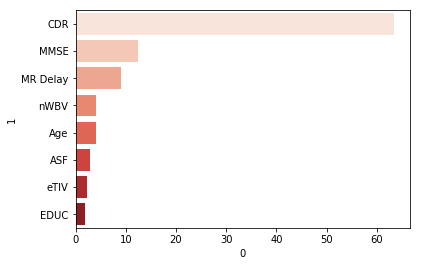

In [72]:
sns.barplot(x=0, y=1, data=features_pd,palette='Reds');
plt.show()

We may eliminate the 3 lowest features to improve the accuracy of our model.


Since we are using the random forest classifier model for feature selection, we have already removed the redundant features, it has been documented below.

-    59.682461        =CDR
-    15.950713       =MMSE
-     6.347773   =MR Delay
-     3.199782        =Age
-     2.930952        =ASF
-     2.584896       =eTIV
-     2.553309       =nWBV
-     2.480296       =EDUC
-     1.743125      =Visit(Removed)
-     1.286240        =M/F(Removed)
-    1.240452        =SES(Removed)

## 1) Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

In [73]:
from sklearn.metrics import accuracy_score

y_predict = random_forest.predict(X_test)
rfscore = 100*accuracy_score(y_test, y_predict)
print('Accuracy of Random Forests Classifier Accuracy is ')
print(100*accuracy_score(y_test,y_predict))


Accuracy of Random Forests Classifier Accuracy is 
92.5531914893617


In [74]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True Alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,3,1,5
True Alzheimers,1,34,0
True converted,0,0,50


Observations:
- The highest accuracy was attained when max_features was set to 5.
- When 5 features are considered for the best split, we obtain the greatest accuracy in this model (92.55%)
- Standardization does not make a difference to the accuracy.

## 2) K Nearest Neighbors Classifier
K nearest neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). 

In [75]:
from sklearn.neighbors import KNeighborsClassifier
nneighbor = KNeighborsClassifier(n_neighbors=8,metric='euclidean')

In [76]:
nneighbor.fit(X_train2, y_train2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [77]:
y_predict = nneighbor.predict(X_test2)
knscore = 100*accuracy_score(y_test2, y_predict)
print('Accuracy of K Nearest Neighbors Classifier is ')
print(100*accuracy_score(y_test2,y_predict))

Accuracy of K Nearest Neighbors Classifier is 
88.29787234042553


In [78]:
pd.DataFrame(
    confusion_matrix(y_test2, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True Alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,0,3,6
True Alzheimers,1,34,0
True converted,1,0,49


Observations:
- Accuracy plateaus after using 8 neighbors.
- Accuracy remains the same with all distance measures ( minkowski, manhattan, euclidean ).


## 3) Decision Tree Classifier
Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).

In [32]:
from sklearn.tree import DecisionTreeClassifier
dectree = DecisionTreeClassifier(max_features=5)

In [33]:
dectree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [34]:
y_predict = dectree.predict(X_test)
decscore=100*accuracy_score(y_test, y_predict)
print('Accuracy of Decision Tree Classifier is ')
print(100*accuracy_score(y_test,y_predict))

Accuracy of Decision Tree Classifier is 
80.85106382978722


In [35]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True Alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,3,1,5
True Alzheimers,8,26,1
True converted,3,0,47


Observations:
- Max_features is selected as 5, this means that when 5 features are selected for the best split, accuracy is the highest.

## 4) Naive Baye's Classifier
Naive Bayes is a kind of classifier which uses the Bayes Theorem. It predicts membership probabilities for each class such as the probability that given record or data point belongs to a particular class.  The class with the highest probability is considered as the most likely class.

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [37]:
gnb.fit(X_train,y_train)

GaussianNB(priors=None)

In [38]:
y_predict = gnb.predict(X_test)
nbscore = 100*accuracy_score(y_test, y_predict)
print('Accuracy of Naive Bayes Classifier is ')
print(100*accuracy_score(y_test,y_predict))

Accuracy of Naive Bayes Classifier is 
90.42553191489363


In [39]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Healthy', 'Predicted alzheimers','Predicted Converted'],
    index=['True Healthy', 'True alzheimers','True converted']
)

,Predicted Healthy,Predicted alzheimers,Predicted Converted
True Healthy,2,1,6
True alzheimers,2,33,0
True converted,0,0,50


Observations:
- Parameters have not been tuned because the only parameter available for tuning is priors (Prior probabilities of the class).
- It is best to leave priors at 'None' because the priors will be adjusted automatically based on the data.

## 5) Support Vector Classifier
A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. 

In [40]:
from sklearn.svm import SVC
supvc = SVC(kernel='linear',C=2)

In [41]:
supvc.fit(X_train2,y_train2)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
y_predict = supvc.predict(X_test2)
svcscore=accuracy_score(y_test2,y_predict)*100
print('Accuracy of Support vector classifier is ')
print(100*accuracy_score(y_test2,y_predict))

Accuracy of Support vector classifier is 
92.5531914893617


In [43]:
pd.DataFrame(
    confusion_matrix(y_test2, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True Alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,2,1,6
True Alzheimers,0,35,0
True converted,0,0,50


Observations:
- Extremely low accuracy of 56% when using the RBF kernel.
- High computation time on poly kernel & 90% accuracy.
- Highest accuracy obtained on the linear kernel with 92.55%.
- Accuracy slightly increases when penalty parameter C is set to 2.

## 6) Ada Boost Classifier
Ada-boost classifier combines weak classifier algorithm to form strong classifier. A single algorithm may classify the objects poorly. But if we combine multiple classifiers with selection of training set at every iteration and assigning right amount of weight in final voting, we can have good accuracy score for overall classifier.

In [44]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(algorithm='SAMME')

In [45]:
abc.fit(X_train2,y_train2)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=50, random_state=None)

In [46]:
y_predict = abc.predict(X_test2)
abcscore=accuracy_score(y_test2,y_predict)*100
print('Accuracy of ADA Boost classifier is ')
print(100*accuracy_score(y_test2,y_predict))

Accuracy of ADA Boost classifier is 
90.42553191489363


In [47]:
pd.DataFrame(
    confusion_matrix(y_test2, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,0,3,6
True alzheimers,0,35,0
True converted,0,0,50


Observations:
- Yields higher accuracy when the algorithm used is SAMME and not the default SAMME.R.
- SAMME is a boosting algorithm which works better for multiclass classification, SAMME.R works is conventionally used for binary classification problems.
- Accuracy greatly increases after using standardised data(From 50% to 90%).

### Stuff to do after progress report:
- Implement Neural Networks
- Feature Selection


## 7) Multilayer Perceptron
Multilayer perceptron classifier is a classifier based on the feedforward artificial neural network. MLPC consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network. Nodes in the input layer represent the input data. All other nodes map inputs to outputs by a linear combination of the inputs with the node’s weights w and bias b and applying an activation function. We are using 3 layers of nodes. The solver is used for weight optimization.

In [48]:
from sklearn.neural_network import MLPClassifier


In [49]:
mlp = MLPClassifier(max_iter=500,solver='lbfgs',hidden_layer_sizes=(10,30,20),activation='tanh')


In [50]:
mlp.fit(X_train2,y_train2)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 30, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [51]:
y_predict = mlp.predict(X_test2)
mlpscore = 100*accuracy_score(y_test2,y_predict)
print(mlpscore)

81.91489361702128


In [52]:
from sklearn.metrics import classification_report,confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test2, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,2,0,7
True alzheimers,2,31,2
True converted,6,0,44


Observations:
- Performance greatly increased from 50% to 81.23% after using scaled data.
- Accuracy remains unaffected on changing activation functions.
- According to scikit learn documentation, the solver 'lbfgs' is more appropriate for smaller datasets compared to other solvers such as 'adam'.

## 9) Feed Forward Deep Learning Neural Network

[This Code was Adapted From: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/]

- The Keras library provides a convenient wrapper for deep learning models to be used as classification or regression estimators in scikit-learn. 
- The KerasClassifier class in Keras take an argument build_fn which is the name of the function to call to get your model. You must define a function that defines your model, compiles it and returns it. 
- In the example below, it is called "baseline_model". We pass this function name to the KerasClassifier.
- The model is automatically bundled up and passed on to the fit() function which is called internally by the KerasClassifier class.

In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

lb = LabelBinarizer()
y_train3 =lb.fit_transform(y_train2)


In [60]:
def baseline_model():
	classifier = Sequential()

# Adding the input layer and the first hidden layer
	classifier.add(Dense(activation = 'relu',  input_dim = 8, units = 8, kernel_initializer = 'uniform'))
# Adding the second hidden layer
	classifier.add(Dense( activation = 'relu', units = 15, kernel_initializer = 'uniform'))
# Adding the third hidden layer
	classifier.add(Dense( activation = 'relu', units = 15, kernel_initializer = 'uniform'))

# Adding the output layer
	classifier.add(Dense(activation = 'sigmoid', units = 3, kernel_initializer = 'uniform' ))

# Compiling the ANN
	classifier.compile(optimizer = 'adamax', loss = 'categorical_crossentropy', metrics = ['accuracy'])


# Fitting the ANN to the Training set
	return classifier

In [61]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=5, verbose=0)

In [62]:
estimator.fit(X_train2, y_train2)

In [63]:
y_predict = estimator.predict(X_test2)

In [64]:
ffdnscore = 100*accuracy_score(y_test2,y_predict)
ffdnscore

92.5531914893617

In [65]:
pd.DataFrame(
    confusion_matrix(y_test2, y_predict),
    columns=['Predicted Healthy', 'Predicted Alzheimers','Predicted Converted'],
    index=['True Healthy', 'True alzheimers','True converted']
)

,Predicted Healthy,Predicted Alzheimers,Predicted Converted
True Healthy,2,1,6
True alzheimers,0,35,0
True converted,0,0,50


Observations:
- Using the Adamax optimizer we obtain the highest accuracy.
- We start with the input layer, followed by two hidden layers with relu activation functions.
- The output layer is added and the model is compiled.

## COMPARING THE CLASSIFIERS

We have run all five classifiers and obtained the accuracies for each, we will attempt to visaulize the acccuracies to determine the best possible classifier for predicting Alzheimer's disease.

In [66]:
scorearray = [svcscore,nbscore,decscore,knscore,rfscore,abcscore,mlpscore,ffdnscore]
score_arr = [{'Classifier':'SVC','Accuracy':svcscore},
           {'Classifier':'NB','Accuracy':nbscore},
            {'Classifier':'DEC','Accuracy':decscore},
            {'Classifier':'KNN','Accuracy':knscore},
            {'Classifier':'RF','Accuracy':rfscore}
            ,{'Classifier':'ABC','Accuracy':abcscore},
            {'Classifier':'MLP','Accuracy':mlpscore},
            {'Classifier':'FFDN','Accuracy':ffdnscore}]
score_df = pd.DataFrame(score_arr)

Ranking all the classifiers used in ascending order.

In [67]:
score_df = score_df.sort_values('Accuracy')
score_df

,Accuracy,Classifier
2,80.851064,DEC
6,81.914894,MLP
3,88.297872,KNN
1,90.425532,NB
5,90.425532,ABC
4,91.489362,RF
0,92.553191,SVC
7,92.553191,FFDN


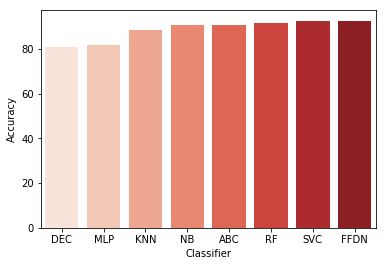

In [68]:
sns.barplot(x="Classifier", y="Accuracy", data=score_df,palette='Reds');
plt.show()

- We can hence clearly observe that the best classifier is the Support Vector Classifier & Random Forest Classifier with 92.55% accuracy.

- The deep learning Multilayer Perceptron with 3 layers yields 87% accuracy, this could possibly be due to the small size of the dataset resulting in overfitting of the model.

- The Deep Learning Network Using Keras Classifier performs better than a tri-layered MLP but the conventional classifiers outperform this network.

- The other classifiers' performances were average with the Decision Tree Classifier being the worst performer with 77.12% accuracy.

- Since Neural Networks are stochastic in nature, they produce random results every time.

## Licenses
- scikit-learn is a Python module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license.
- Keras is a machine learning framework licensed under MIT.